# Stats on pattern distribution for PN-LW around Cu K$\alpha$ (8.04 keV) line

The notebook assumes that `pn_lw_step03_ccd_per_pattern_cti49.py` was run on all observations.

There should be a spectrum extracted from the event list for each CCD and pattern.

In [1]:
import os
import numpy as np
import altair as alt
import pandas as pd

from astropy.table import Table, Column
from astropy.io import fits
home = os.path.expanduser('~')

%matplotlib inline
import matplotlib.pylab as plt
import seaborn as sns
sns.set(style="white")

plt.rc('text', usetex=False)
plt.rc('font', family='serif')

In [65]:
wdir = f"{home}/IVAN/Cu-line"
#
# read a file with the list of available OBSIDs
t = Table.read(f"{wdir}/fit_results_cuka.csv")
obslist, indeces = np.unique(t['obsid'],return_index=True)
nw = len(obslist)

In [66]:
t.info()

<Table length=828>
   name     dtype 
---------- -------
     obsid   int64
       rev   int64
delta_time float64
    ontime float64
       ccd   int64
     lineE float64
 lineE_err float64
      fwhm float64
  fwhm_err float64
      chi2 float64
        df   int64


In [67]:
subfolder = 'cti49'
#
culine = 8.04 # keV
delta = 0.1 #keV
#
fout = open(f'{wdir}/pattern_stats_out.csv','w')
print ("obsid,rev,delta_time,ontime,ccd,pattern,ncounts,frac,ntot",file=fout)
for i in np.arange(nw):
    iobs = obslist[i]
    if (i % 10 == 0): 
        print (f"Processing {iobs}: {i+1}/{nw}")
    irev = t['rev'].data[indeces[i]]
    itime = t['delta_time'].data[indeces[i]]
    iexpo = t['ontime'].data[indeces[i]]
    for iccd in np.arange(1,13):
        ncounts = np.zeros(4,dtype=int)
        for xpat in np.arange(1,5):
            spfile = f'{wdir}/{iobs:010}/{subfolder}/pn_{iccd:02}_pat{xpat:02}_spec5.fits'
            if (not os.path.isfile(spfile)):
                print (f"Cannot find spectrum file for OB_ID: {iobs}, CCD: {iccd}, PATTERN: {xpat}")
                raise FileNotFoundError
            #
            hdu = fits.open(spfile)
            spx = hdu['SPECTRUM']
            energy = spx.data['CHANNEL']*5.0/1000.0 # in keV
            counts = spx.data['COUNTS']
            cumask = (energy <= (culine + delta)) & (energy >= (culine - delta))
            ix = np.where(cumask)[0]
            nevt = np.count_nonzero(energy[ix])
            ncounts[xpat-1] = np.sum(counts[ix])
            hdu.close()
            #
            #print (f"{iobs:010},{irev},{itime},{iexpo},{iccd},{xpat},{nevt},{ncounts},{rate:.5f}")
        ntot = np.sum(ncounts)
        for xpat in np.arange(1,5):
            print (f"{iobs:010},{irev},{itime},{iexpo},{iccd},{xpat},{ncounts[xpat-1]},{ncounts[xpat-1]/ntot},{ntot}",file=fout)
#
fout.close()
print ("Done")

Processing 142270101: 1/69
Processing 302850201: 11/69
Processing 555870201: 21/69
Processing 674440101: 31/69
Processing 744490401: 41/69
Processing 761500201: 51/69
Processing 780690301: 61/69
Done


In [68]:
tstat = Table.read(f'{wdir}/pattern_stats_out.csv')
#td = tstat.to_pandas()
tccd = tstat.group_by('ccd')

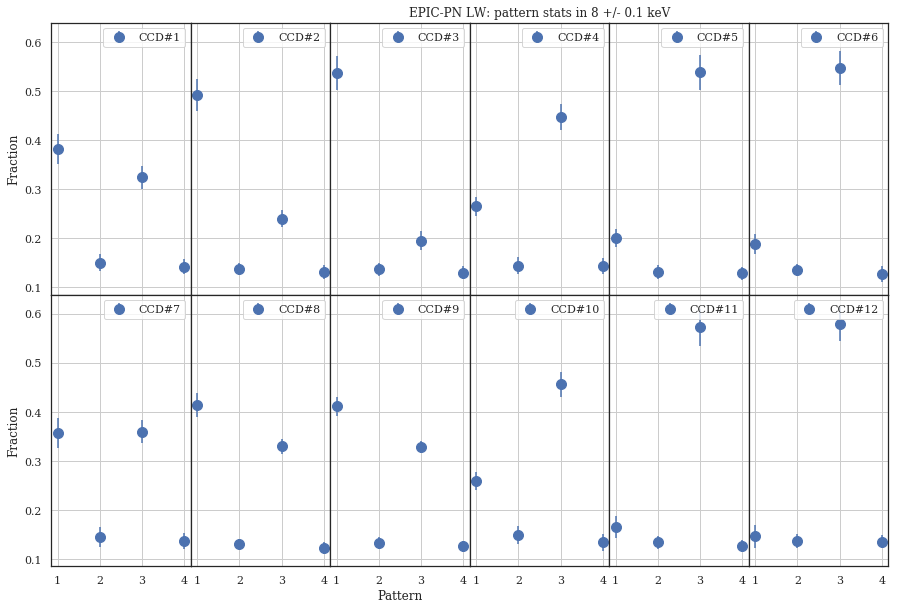

In [69]:
fig, axs = plt.subplots(2,6,sharex=True,sharey=True,figsize=(15,10))
for j in range(12):
    ccd = j+1
    qmask = (tccd.groups.keys['ccd'] == ccd)
    tq = tccd.groups[qmask]
    spread = []
    center = []
    fmin = []
    fmax = []
    xxpat = np.arange(1,5)
    for xpat in np.arange(1,5):
        #
        tpat = tq.group_by('pattern')
        pmask = tpat.groups.keys['pattern'] == xpat
        spread.append(np.std(tpat.groups[pmask]['frac']))
        center.append(np.mean(tpat.groups[pmask]['frac']))
        fmin.append(np.min(tpat.groups[pmask]['frac']))
        fmax.append(np.max(tpat.groups[pmask]['frac']))
    k = j
    kj = 0
    if (j >= 6):
        k = j - 6
        kj = 1
    axs[kj,k].errorbar(xxpat,center,yerr=(spread,spread),fmt='o',label=f'CCD#{ccd}',markersize=10)
    axs[kj,k].grid(True)
    if (ccd == 4):
        axs[kj,k].set_title("EPIC-PN LW: pattern stats in 8 +/- 0.1 keV")
    if (ccd == 7 or ccd == 1):
        axs[kj,k].set_ylabel(r"Fraction")
    if (ccd == 9):
        axs[kj,k].set_xlabel("Pattern")
    axs[kj,k].legend()
    
plt.subplots_adjust(wspace=0, hspace=0)
plt.savefig(f"{wdir}/pattern_stat.png",dpi=100)
plt.show()
plt.close();

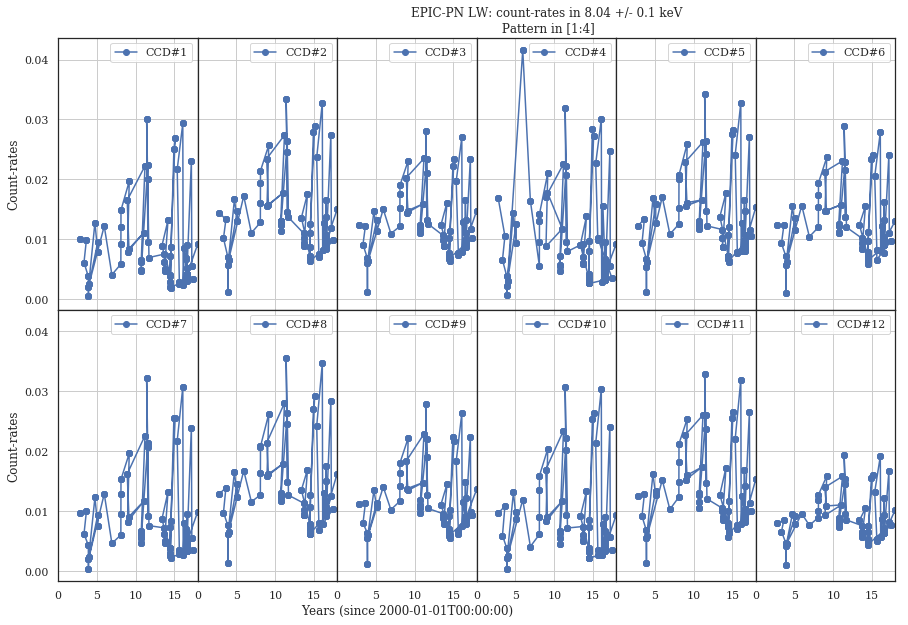

In [72]:
#
# plot rate as a function of time
#
tstat = Table.read(f'{wdir}/pattern_stats_out.csv')
#td = tstat.to_pandas()
tccd = tstat.group_by('ccd')
fig, axs = plt.subplots(2,6,sharex=True,sharey=True,figsize=(15,10))
for j in range(12):
    ccd = j+1
    qmask = (tccd.groups.keys['ccd'] == ccd)
    tq = tccd.groups[qmask]
    k = j
    kj = 0
    if (j >= 6):
        k = j - 6
        kj = 1
    axs[kj,k].plot(tq['delta_time'],tq['ntot']/tq['ontime'],'-o',label=f'CCD#{ccd}')
    axs[kj,k].grid(True)
    if (ccd == 4):
        axs[kj,k].set_title("EPIC-PN LW: count-rates in 8.04 +/- 0.1 keV\n Pattern in [1:4]")
    if (ccd == 7 or ccd == 1):
        axs[kj,k].set_ylabel(r"Count-rates")
    if (ccd == 9):
        axs[kj,k].set_xlabel("Years (since 2000-01-01T00:00:00)")
    axs[kj,k].legend()
    axs[kj,k].set_xlim((0.0,18))
    
plt.subplots_adjust(wspace=0, hspace=0)
#plt.savefig(f"{wdir}/pattern_stat.png",dpi=100)
plt.show()
plt.close();

## Plot the fit results per CCD and PATTERN

This uses `EPN_CTI_0049.CCF_test52` the test CCF with the new shifts at 8 keV for all PATTERNs. Have to do the same with test 51 with the original shifts only at 5.8988 keV.

CCD#01, pattern: 01, mean offset: 0.2, stdev: 41.8
CCD#01, pattern: 02, mean offset: 0.7, stdev: 72.2
CCD#01, pattern: 03, mean offset: 1.6, stdev: 56.9
CCD#01, pattern: 04, mean offset: -1.1, stdev: 78.2
CCD#02, pattern: 01, mean offset: -1.3, stdev: 12.8
CCD#02, pattern: 02, mean offset: -0.0, stdev: 20.9
CCD#02, pattern: 03, mean offset: -0.6, stdev: 18.5
CCD#02, pattern: 04, mean offset: -0.5, stdev: 23.5
CCD#03, pattern: 01, mean offset: 0.4, stdev: 10.1
CCD#03, pattern: 02, mean offset: 0.7, stdev: 23.4
CCD#03, pattern: 03, mean offset: -1.0, stdev: 17.8
CCD#03, pattern: 04, mean offset: 0.5, stdev: 18.5
CCD#04, pattern: 01, mean offset: -6.3, stdev: 59.9
CCD#04, pattern: 02, mean offset: 1.5, stdev: 81.6
CCD#04, pattern: 03, mean offset: 5.8, stdev: 48.7
CCD#04, pattern: 04, mean offset: 3.4, stdev: 83.0
CCD#05, pattern: 01, mean offset: -0.9, stdev: 24.3
CCD#05, pattern: 02, mean offset: 0.2, stdev: 28.1
CCD#05, pattern: 03, mean offset: -0.6, stdev: 12.4
CCD#05, pattern: 04, m

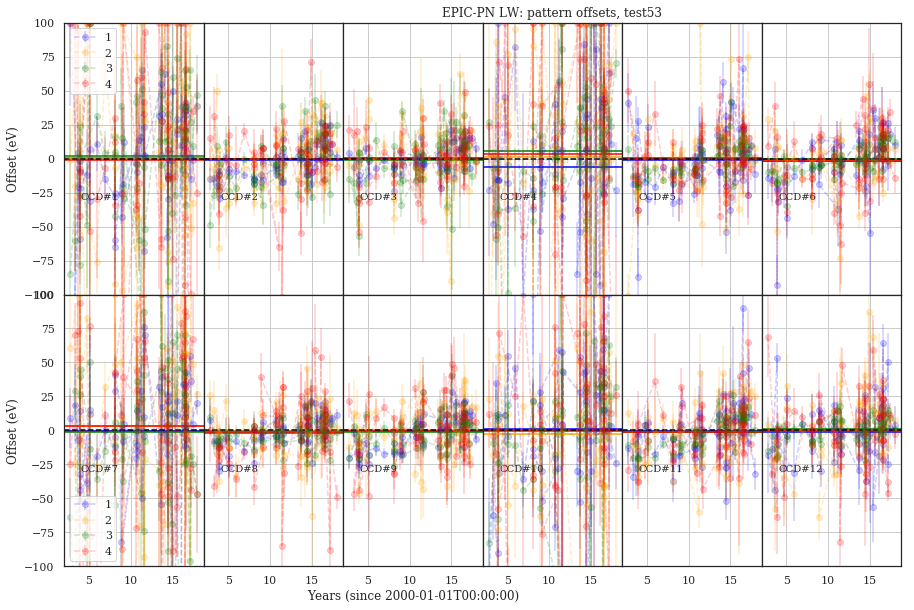

In [122]:
vtest = "test53"
# test version
toff = Table.read(f'{wdir}/fit_results_cuka_patterns_cti49_{vtest}.csv')
ddd = (toff['lineE'].data - 8.04)*1000
toff.add_column(Column(ddd,name='deltaE'))
tccd = toff.group_by('ccd')
#
fig, axs = plt.subplots(2,6,sharex=True,sharey=True,figsize=(15,10))
#
offsets = np.zeros((4,12))
offsets_std = np.zeros((4,12))

#
colx = {1:'blue',2:'orange', 3:'green',4:'red'}
#
fout = open(f'{wdir}/derived_offsets_per_pattern_{vtest}.csv','w')
print ("ccd,pattern,offset,rms",file=fout)
#
for j in range(12):
    ccd = j+1
    qmask = (tccd.groups.keys['ccd'] == ccd)
    tq = tccd.groups[qmask]
    for xpat in range(1,5):
        #
        tpat = tq.group_by('pattern')
        pmask = tpat.groups.keys['pattern'] == xpat
        k = j
        kj = 0
        if (j >= 6):
            k = j - 6
            kj = 1
        offsets[xpat-1,j] = np.mean(tpat.groups[pmask]['deltaE'])
        offsets_std[xpat-1,j] = np.std(tpat.groups[pmask]['deltaE'])
        axs[kj,k].errorbar(tpat.groups[pmask]['delta_time'],tpat.groups[pmask]['deltaE'],yerr=1000*tpat.groups[pmask]['lineE_err'],
                           color=colx[xpat],fmt='o',alpha=0.2,linestyle='dashed',label=f"{xpat}")
        axs[kj,k].axhline(offsets[xpat-1,j],color=colx[xpat])
        #
        print (f"CCD#{ccd:02}, pattern: {xpat:02}, mean offset: {offsets[xpat-1,j]:.1f}, stdev: {offsets_std[xpat-1,j]:.1f}")
        print (f"{ccd:02},{xpat:02},{offsets[xpat-1,j]:.1f},{offsets_std[xpat-1,j]:.1f}",file=fout)
    axs[kj,k].text(4.0,-30.0,f'CCD#{ccd}')
    axs[kj,k].axhline(0.00,color='black',linestyle='dashed')
    axs[kj,k].grid()
    if (ccd == 4):
        axs[kj,k].set_title(f"EPIC-PN LW: pattern offsets, {vtest}")
    if (ccd == 7 or ccd == 1):
        axs[kj,k].set_ylabel(r"Offset (eV)")
        axs[kj,k].legend()
    if (ccd == 9):
        axs[kj,k].set_xlabel("Years (since 2000-01-01T00:00:00)")
    axs[kj,k].set_ylim((-100,100))
#
fout.close()
plt.subplots_adjust(wspace=0, hspace=0)
plt.savefig(f"{wdir}/offsets_patterns_{vtest}.png",dpi=100)
plt.show()
plt.close();

## Incorporate the derived shifts (offsets) in the cal file

There should be 60 new lines with shift entry at 8.04 keV for each CCD and each pattern for PN Large Window mode (`MODE_ID == 2`)

**Note**: the new shifts are on top of the already available shifts at 5.8988 keV!

In [118]:
import time
today = time.strftime("%c")
#
extname = 'COMB_EVT_OFFSET'
#
ccf49_file = f"{wdir}/../ccfdev/EPN_CTI_0049.CCF_test51"
hdu49 = fits.open(f"{ccf49_file}")
ltc49 = hdu49[extname]
# only PN Large Window mode
ix49 = np.where(ltc49.data['MODE_ID'] == 2)[0]
#
# now extract the shifts at 5.8988, as we need to add the new one on top of this
#
shift6 = np.zeros((5,12))
for ccd in np.arange(1,13):
    for patt in np.arange(5):
        vv = np.where((ltc49.data['MODE_ID'] == 2) & (ltc49.data['CCD_ID'] == ccd) & (ltc49.data['PATTERN'] == patt) & 
                      (ltc49.data['ENERGY'] > 5.0))[0]
        shift6[patt,ccd-1] = ltc49.data['SHIFT'][vv[0]]
nrows = ltc49.data.shape[0]
xhdu = fits.BinTableHDU.from_columns(ltc49.columns, nrows=nrows+12*5,name=extname,header=ltc49.header)
#xhdu = fits.BinTableHDU.from_columns(ltc49.columns,name=extname,header=ltc49.header)
npat = 5 # number of patterns
for ccd in np.arange(1,13):
    for patt in np.arange(5):
        k = nrows + (ccd-1)*npat + patt
        xhdu.data['MODE_ID'][k] = 2
        xhdu.data['CCD_ID'][k] = ccd
        xhdu.data['PATTERN'][k] = patt
        xhdu.data['ENERGY'][k] = 8.04
        if (patt == 0):
            xhdu.data['SHIFT'][k] = 0.0
        else:
            xhdu.data['SHIFT'][k] = shift6[patt,ccd-1] + offsets[patt-1,ccd-1]
        print (f"ccd: {ccd}, pattern: {patt}, shift6: {shift6[patt,ccd-1]:.1f}, shift8: {offsets[patt-1,ccd-1]:.1f}, total: {xhdu.data['SHIFT'][k]:.1f}")
#

ccd: 1, pattern: 0, shift6: 0.0, shift8: 6.4, total: 0.0
ccd: 1, pattern: 1, shift6: 47.4, shift8: 31.1, total: 78.5
ccd: 1, pattern: 2, shift6: 4.9, shift8: 5.6, total: 10.5
ccd: 1, pattern: 3, shift6: 37.3, shift8: 28.0, total: 65.3
ccd: 1, pattern: 4, shift6: -5.8, shift8: 6.4, total: 0.6
ccd: 2, pattern: 0, shift6: 0.0, shift8: 4.1, total: 0.0
ccd: 2, pattern: 1, shift6: 42.6, shift8: 36.6, total: 79.2
ccd: 2, pattern: 2, shift6: 5.1, shift8: 12.4, total: 17.5
ccd: 2, pattern: 3, shift6: 32.1, shift8: 23.2, total: 55.3
ccd: 2, pattern: 4, shift6: -6.9, shift8: 4.1, total: -2.8
ccd: 3, pattern: 0, shift6: 0.0, shift8: 0.3, total: 0.0
ccd: 3, pattern: 1, shift6: 36.2, shift8: 26.6, total: 62.8
ccd: 3, pattern: 2, shift6: 2.3, shift8: 5.5, total: 7.8
ccd: 3, pattern: 3, shift6: 29.0, shift8: 14.6, total: 43.6
ccd: 3, pattern: 4, shift6: -7.9, shift8: 0.3, total: -7.6
ccd: 4, pattern: 0, shift6: 0.0, shift8: 9.3, total: 0.0
ccd: 4, pattern: 1, shift6: 62.5, shift8: 25.6, total: 88.1
cc

In [119]:
idx_sorted = np.lexsort((xhdu.data['ENERGY'],xhdu.data['PATTERN'],xhdu.data['CCD_ID'],xhdu.data['MODE_ID']))
xhdu.data = xhdu.data[idx_sorted]
#xhdu.header.remove('HISTORY',remove_all=True)
xhdu.header.add_history(f'Created by Ivan V, {today}')
hdu49[extname] = xhdu
hdu49[0].header['FILENAME'] = "EPN_CTI_0049.CCF"
hdu49.writeto(f"{wdir}/../ccfdev/EPN_CTI_0049.CCF_test53",overwrite=True)
hdu49.close()

In [120]:
df = pd.DataFrame(hdu49[extname].data)

In [121]:
#
# let's check if it's all OK
#
df[df.MODE_ID == 2]

,MODE_ID,CCD_ID,PATTERN,ENERGY,SHIFT
240,2,1,0,1.4860,0.000000
241,2,1,0,5.8988,0.000000
242,2,1,0,8.0400,0.000000
243,2,1,1,1.4860,-5.600000
244,2,1,1,5.8988,47.400002
245,2,1,1,8.0400,78.544930
246,2,1,2,1.4860,-20.200001
247,2,1,2,5.8988,4.900000
248,2,1,2,8.0400,10.523189
249,2,1,3,1.4860,-7.300000
